# Cluster Analysis with Normalized Data (Rough Copy)

In [2]:
import collections
import os
import re
import json

import numpy as np
import pandas as pd
import nltk
import sklearn.cross_validation as skcv
import sklearn.decomposition as skd
import sklearn.ensemble as skens
import sklearn.feature_extraction.text as skft
import sklearn.naive_bayes as sknb
import sklearn.pipeline as skpipe
import scipy as sp
import scipy.spatial.distance as spd
import scipy.cluster.hierarchy as sph
import sklearn as sk
import sklearn.metrics as skm
import sklearn.cluster as skc
import sklearn.decomposition as skd
import sklearn.mixture as skmix
import sklearn.preprocessing as skp
from ast import literal_eval
from nltk.util import ngrams
from sklearn import metrics
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
from pandas.tools.plotting import radviz
from pandas.tools.plotting import bootstrap_plot
from pandas.tools.plotting import lag_plot
from pandas.tools.plotting import parallel_coordinates
from pandas.tools.plotting import andrews_curves

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='whitegrid', color_codes=True, font_scale=1.3)
sns.set(style='white', color_codes=True, font_scale=1.3)

In [3]:
df = pd.DataFrame.from_csv('cluster.csv', index_col=0)

In [4]:
df = df.rename(columns=lambda x: x.strip())

In [5]:
df.shape
df.payment_type.unique()

array(['CSH', 'DIS', 'NOC', 'CRD', 'UNK'], dtype=object)

In [6]:
dfclean = df.copy()

In [7]:
dfclean["CMT"] = 0
dfclean["VTS"] = 0
dfclean["CSH"] = 0
dfclean["DIS"] = 0
dfclean["NOC"] = 0
dfclean["CRD"] = 0
dfclean["UNKNOWN"] = 0


dfclean.loc[dfclean['vendor_id'] == 'CMT','CMT'] = 1
dfclean.loc[dfclean['vendor_id'] == 'VTS','VTS'] = 1
dfclean.loc[dfclean['payment_type'] == 'CSH','CSH'] = 1
dfclean.loc[dfclean['payment_type'] == 'DIS','DIS'] = 1
dfclean.loc[dfclean['payment_type'] == 'NOC','NOC'] = 1
dfclean.loc[dfclean['payment_type'] == 'CRD','CRD'] = 1
dfclean.loc[dfclean['payment_type'] == 'UNKNOWN','UNKNOWN'] = 1

dfclean.head()

,hack_license,vendor_id,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,rate_code,passenger_count,trip_time_in_secs,trip_distance,CMT,VTS,CSH,DIS,NOC,CRD,UNKNOWN
medallion,,,,,,,,,,,,,,,,,,,,
89D227B655E5C82AECF13C3F540D4CF4,BA96DE419E711691B9445D6A6307C170,CMT,CSH,6.5,0.0,0.5,0,0,7.0,1,4,382,1.0,1,0,1,0,0,0,0
0BD7C8F5BA12B88E0B67BED28BEA73D8,9FD8F69F0804BDB5549F40E9DA1BE472,CMT,CSH,6.0,0.5,0.5,0,0,7.0,1,1,259,1.5,1,0,1,0,0,0,0
0BD7C8F5BA12B88E0B67BED28BEA73D8,9FD8F69F0804BDB5549F40E9DA1BE472,CMT,CSH,5.5,1.0,0.5,0,0,7.0,1,1,282,1.1,1,0,1,0,0,0,0
DFD2202EE08F7A8DC9A57B02ACB81FE2,51EE87E3205C985EF8431D850C786310,CMT,CSH,5.0,0.5,0.5,0,0,6.0,1,2,244,0.7,1,0,1,0,0,0,0
DFD2202EE08F7A8DC9A57B02ACB81FE2,51EE87E3205C985EF8431D850C786310,CMT,CSH,9.5,0.5,0.5,0,0,10.5,1,1,560,2.1,1,0,1,0,0,0,0


In [109]:
# dfclean.loc[dfclean['vendor_id'] == "CMT",'vendor_id'] = 0
# dfclean.loc[dfclean['vendor_id'] == "VTS",'vendor_id'] = 1
# dfclean.loc[dfclean['payment_type'] == "CSH",'payment_type'] = 0
# dfclean.loc[dfclean['payment_type'] == "DIS",'payment_type'] = 1
# dfclean.loc[dfclean['payment_type'] == "NOC",'payment_type'] = 2
# dfclean.loc[dfclean['payment_type'] == "CRD",'payment_type'] = 3
# dfclean.loc[dfclean['payment_type'] == "UNKNOWN",'payment_type'] = 4

# dfclean

In [8]:
# dfclean = dfclean.drop(dfclean.columns[[0,1,2,-1]], axis=1)
dfclean.head()

,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,rate_code,passenger_count,trip_time_in_secs,trip_distance,CMT,VTS,CSH,DIS,NOC,CRD
medallion,,,,,,,,,,,,,,,,
89D227B655E5C82AECF13C3F540D4CF4,6.5,0.0,0.5,0,0,7.0,1,4,382,1.0,1,0,1,0,0,0
0BD7C8F5BA12B88E0B67BED28BEA73D8,6.0,0.5,0.5,0,0,7.0,1,1,259,1.5,1,0,1,0,0,0
0BD7C8F5BA12B88E0B67BED28BEA73D8,5.5,1.0,0.5,0,0,7.0,1,1,282,1.1,1,0,1,0,0,0
DFD2202EE08F7A8DC9A57B02ACB81FE2,5.0,0.5,0.5,0,0,6.0,1,2,244,0.7,1,0,1,0,0,0
DFD2202EE08F7A8DC9A57B02ACB81FE2,9.5,0.5,0.5,0,0,10.5,1,1,560,2.1,1,0,1,0,0,0


In [9]:
dfnorm = dfclean.apply(lambda x: (x-x.mean())/x.std())
dfnorm.head()

,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,rate_code,passenger_count,trip_time_in_secs,trip_distance,CMT,VTS,CSH,DIS,NOC,CRD
medallion,,,,,,,,,,,,,,,,
89D227B655E5C82AECF13C3F540D4CF4,-0.541407,-0.832829,0.056976,-0.609327,-0.214,-0.606999,-0.129678,1.084813,-0.623546,-0.560465,16.601073,-16.601073,1.064105,-0.001381,-0.000977,-1.062129
0BD7C8F5BA12B88E0B67BED28BEA73D8,-0.590119,0.514916,0.056976,-0.609327,-0.214,-0.606999,-0.129678,-0.656049,-0.874057,-0.414516,16.601073,-16.601073,1.064105,-0.001381,-0.000977,-1.062129
0BD7C8F5BA12B88E0B67BED28BEA73D8,-0.638831,1.862662,0.056976,-0.609327,-0.214,-0.606999,-0.129678,-0.656049,-0.827213,-0.531276,16.601073,-16.601073,1.064105,-0.001381,-0.000977,-1.062129
DFD2202EE08F7A8DC9A57B02ACB81FE2,-0.687543,0.514916,0.056976,-0.609327,-0.214,-0.688798,-0.129678,-0.075762,-0.904607,-0.648035,16.601073,-16.601073,1.064105,-0.001381,-0.000977,-1.062129
DFD2202EE08F7A8DC9A57B02ACB81FE2,-0.249134,0.514916,0.056976,-0.609327,-0.214,-0.320703,-0.129678,-0.656049,-0.261017,-0.239377,16.601073,-16.601073,1.064105,-0.001381,-0.000977,-1.062129


In [25]:
dfsample = dfnorm.sample(n=4000)
dfsample.shape
dfsample.head()

,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,rate_code,passenger_count,trip_time_in_secs,trip_distance,CMT,VTS,CSH,DIS,NOC,CRD
medallion,,,,,,,,,,,,,,,,
125A1E8783A1DE113702DB138C388C24,-0.784967,-0.832829,0.056976,-0.609327,-0.214000,-0.811496,-0.129678,1.665101,-1.034955,-0.680144,-0.060237,0.060237,1.064105,-0.001381,-0.000977,-1.062129
DB9C06A85E95FD70421DFFD94BE9022D,-0.395270,1.862662,0.056976,-0.144539,-0.214000,-0.320703,-0.129678,-0.656049,-0.301750,-0.335704,-0.060237,0.060237,-0.939756,-0.001381,-0.000977,0.941505
3C53F252CAFA1D436C2A8DEABC725B71,1.650639,-0.832829,0.056976,2.086443,3.977198,2.100546,-0.129678,1.665101,2.508866,1.602500,-0.060237,0.060237,-0.939756,-0.001381,-0.000977,0.941505
546E689A5A5151E24584B1B3BFC63B92,-0.541407,-0.832829,0.056976,-0.144539,-0.214000,-0.525200,-0.129678,-0.656049,-0.668352,-0.563384,-0.060237,0.060237,-0.939756,-0.001381,-0.000977,0.941505
DD1049F02A8B3A68274242954A8AA081,1.017381,-0.832829,0.056976,-0.609327,-0.214000,0.701784,-0.129678,2.245388,0.920257,1.062488,-0.060237,0.060237,1.064105,-0.001381,-0.000977,-1.062129


In [36]:
#STEP 1
# https://en.wikipedia.org/wiki/Hamming_distance

dist = spd.squareform(spd.pdist(dfsample, metric='hamming'))
dist.shape

(4000, 4000)

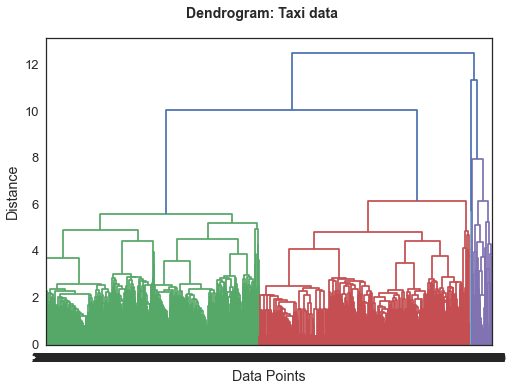

In [39]:
linkz = sph.linkage(dist, method='weighted')  # obtain the linkage matrix
plotz = sph.dendrogram(linkz)  # plot the linkage matrix as a dendrogram
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.suptitle('Dendrogram: Taxi data', 
             fontweight='bold', fontsize=14);

In [158]:
clusterlabels = sph.fcluster(linkz, 8, criterion='distance')
dfsample['Cluster Label'] = clusterlabels
dfsample.head()

C:\Users\Joer\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,rate_code,passenger_count,trip_time_in_secs,trip_distance,CMT,VTS,CSH,DIS,NOC,CRD,Cluster Label
medallion,,,,,,,,,,,,,,,,,
125A1E8783A1DE113702DB138C388C24,-0.784967,-0.832829,0.056976,-0.609327,-0.214000,-0.811496,-0.129678,1.665101,-1.034955,-0.680144,-0.060237,0.060237,1.064105,-0.001381,-0.000977,-1.062129,2
DB9C06A85E95FD70421DFFD94BE9022D,-0.395270,1.862662,0.056976,-0.144539,-0.214000,-0.320703,-0.129678,-0.656049,-0.301750,-0.335704,-0.060237,0.060237,-0.939756,-0.001381,-0.000977,0.941505,1
3C53F252CAFA1D436C2A8DEABC725B71,1.650639,-0.832829,0.056976,2.086443,3.977198,2.100546,-0.129678,1.665101,2.508866,1.602500,-0.060237,0.060237,-0.939756,-0.001381,-0.000977,0.941505,4
546E689A5A5151E24584B1B3BFC63B92,-0.541407,-0.832829,0.056976,-0.144539,-0.214000,-0.525200,-0.129678,-0.656049,-0.668352,-0.563384,-0.060237,0.060237,-0.939756,-0.001381,-0.000977,0.941505,1
DD1049F02A8B3A68274242954A8AA081,1.017381,-0.832829,0.056976,-0.609327,-0.214000,0.701784,-0.129678,2.245388,0.920257,1.062488,-0.060237,0.060237,1.064105,-0.001381,-0.000977,-1.062129,2


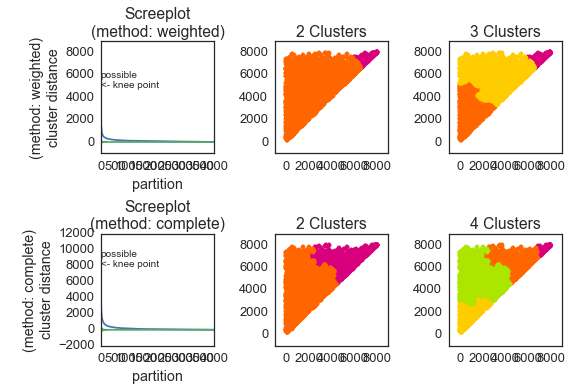

In [159]:
import scipy.cluster.hierarchy as hac

fig, axes23 = plt.subplots(2, 3)

for method, axes in zip(['weighted', 'complete'], axes23):
    z = hac.linkage(linkz, method=method)

    # Plotting
    axes[0].plot(range(1, len(z)+1), z[::-1, 2])
    knee = np.diff(z[::-1, 2], 2)
    axes[0].plot(range(2, len(z)), knee)

    num_clust1 = knee.argmax() + 2
    knee[knee.argmax()] = 0
    num_clust2 = knee.argmax() + 2

    axes[0].text(num_clust1, z[::-1, 2][num_clust1-1], 'possible\n<- knee point')

    part1 = hac.fcluster(z, num_clust1, 'maxclust')
    part2 = hac.fcluster(z, num_clust2, 'maxclust')

    clr = ['#2200CC' ,'#D9007E' ,'#FF6600' ,'#FFCC00' ,'#ACE600' ,'#0099CC' ,
    '#8900CC' ,'#FF0000' ,'#FF9900' ,'#FFFF00' ,'#00CC01' ,'#0055CC']

    for part, ax in zip([part1, part2], axes[1:]):
        for cluster in set(part):
            ax.scatter(linkz[part == cluster, 0], linkz[part == cluster, 1], 
                       color=clr[cluster])

    m = '\n(method: {})'.format(method)
    plt.setp(axes[0], title='Screeplot{}'.format(m), xlabel='partition',
             ylabel='{}\ncluster distance'.format(m))
    plt.setp(axes[1], title='{} Clusters'.format(num_clust1))
    plt.setp(axes[2], title='{} Clusters'.format(num_clust2))

plt.tight_layout()
plt.show()

In [161]:
#k = 3 gives highest silhouette score
for k in range(2,10):
    kmeans_model = skc.KMeans(n_clusters=k, random_state=0).fit(dfsample)
    score = skm.silhouette_score(dfsample, kmeans_model.labels_)
    print('k = %d, silhouette_score = %f'%(k, score))

k = 2, silhouette_score = 0.609222
k = 3, silhouette_score = 0.609952
k = 4, silhouette_score = 0.388312
k = 5, silhouette_score = 0.395042
k = 6, silhouette_score = 0.386465
k = 7, silhouette_score = 0.384093
k = 8, silhouette_score = 0.391587
k = 9, silhouette_score = 0.333222


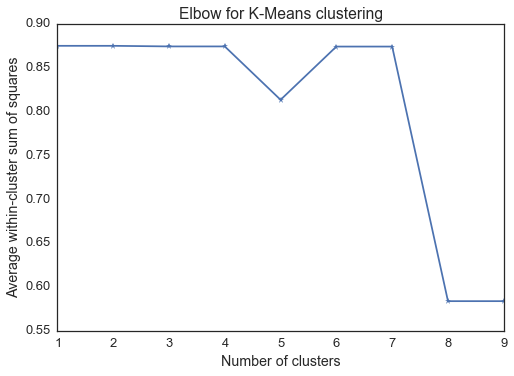

In [162]:
X = dfsample.ix[:,:-1]  # Using the the dataset of Section 1
K = range(1,10)  
kmeans_models = [skc.KMeans(k).fit(X) for k in K]
centroids = [m.cluster_centers_ for m in kmeans_models]
D_k = [spd.cdist(X, cent, 'hamming') for cent in centroids]
cIdx = [np.argmin(D,axis=1) for D in D_k]
dist = [np.min(D,axis=1) for D in D_k]
avgWithinSS = [sum(d)/X.shape[0] for d in dist]

# plot elbow curve
plt.plot(K, avgWithinSS, 'b*-')
plt.xlabel('Number of clusters');
plt.ylabel('Average within-cluster sum of squares');
plt.title('Elbow for K-Means clustering');

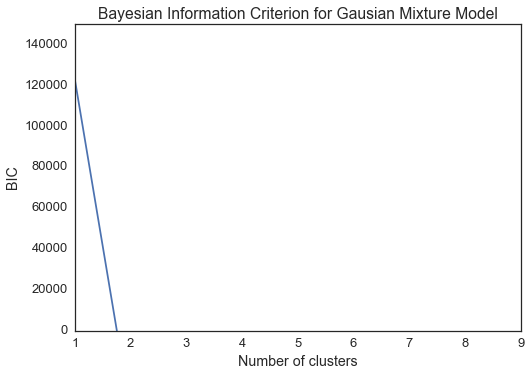

In [163]:
X = dfsample.ix[:,:-1]  # Using the the dataset of Section 1
K = range(1,10)  # Apply kmeans 1 to 10
gmms = [skmix.GMM(k).fit(X) for k in K]
bics = [g.bic(X) for g in gmms]
plt.plot(K, bics)
kIdx = np.argmin(bics)  # <-- the selected index
plt.plot(K[kIdx], bics[kIdx], marker='o', markersize=12, 
      markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
plt.ylim(0,plt.ylim()[1])
plt.xlabel('Number of clusters')
plt.ylabel('BIC')
plt.title('Bayesian Information Criterion for Gausian Mixture Model')

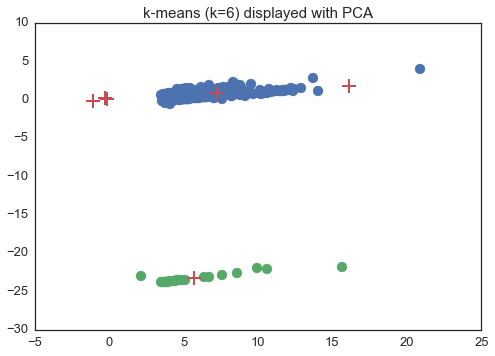

In [84]:
# PCA for dimensionality reduction
pca = skd.PCA(n_components=6)
traits_pca = pca.fit_transform(dfsample)

# K-means
kmeans_model = skc.KMeans(6).fit(dfsample)
centroids = kmeans_model.cluster_centers_
centroids_pca = pca.transform(centroids)
cluster_labels = kmeans_model.labels_

# Plot the results on 2-D scatterplot with cluster centroids
plt.scatter(traits_pca[cluster_labels==0,0], 
            traits_pca[cluster_labels==0,1],
            s=100, color='b')
plt.scatter(traits_pca[cluster_labels==1,0], 
            traits_pca[cluster_labels==1,1],
            s=100, color='g')
plt.scatter(centroids_pca[:,0], centroids_pca[:,1], marker='+', s=200,
            linewidths=2, color='r')
plt.title('k-means (k=6) displayed with PCA', fontsize=15);

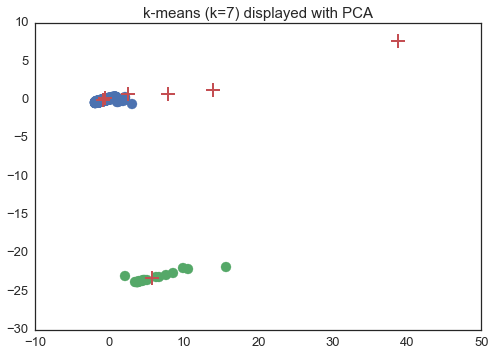

In [85]:
# PCA for dimensionality reduction
pca = skd.PCA(n_components=7)
traits_pca = pca.fit_transform(dfsample)

# K-means
kmeans_model = skc.KMeans(7).fit(dfsample)
centroids = kmeans_model.cluster_centers_
centroids_pca = pca.transform(centroids)
cluster_labels = kmeans_model.labels_

# Plot the results on 2-D scatterplot with cluster centroids
plt.scatter(traits_pca[cluster_labels==0,0], 
            traits_pca[cluster_labels==0,1],
            s=100, color='b')
plt.scatter(traits_pca[cluster_labels==1,0], 
            traits_pca[cluster_labels==1,1],
            s=100, color='g')
plt.scatter(centroids_pca[:,0], centroids_pca[:,1], marker='+', s=200,
            linewidths=2, color='r')
plt.title('k-means (k=7) displayed with PCA', fontsize=15);

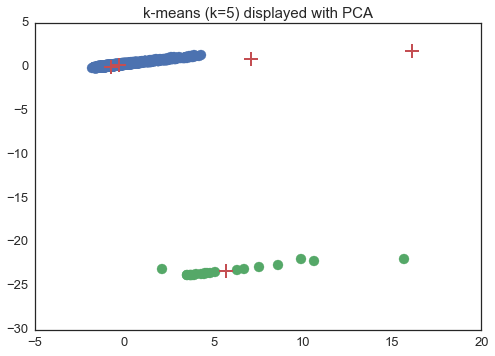

In [90]:
# PCA for dimensionality reduction
pca = skd.PCA(n_components=5)
traits_pca = pca.fit_transform(dfsample)

# K-means
kmeans_model = skc.KMeans(5).fit(dfsample)
centroids = kmeans_model.cluster_centers_
centroids_pca = pca.transform(centroids)
cluster_labels = kmeans_model.labels_

# Plot the results on 2-D scatterplot with cluster centroids
plt.scatter(traits_pca[cluster_labels==0,0], 
            traits_pca[cluster_labels==0,1],
            s=100, color='b')
plt.scatter(traits_pca[cluster_labels==1,0], 
            traits_pca[cluster_labels==1,1],
            s=100, color='g')
plt.scatter(centroids_pca[:,0], centroids_pca[:,1], marker='+', s=200,
            linewidths=2, color='r')
plt.title('k-means (k=5) displayed with PCA', fontsize=15);

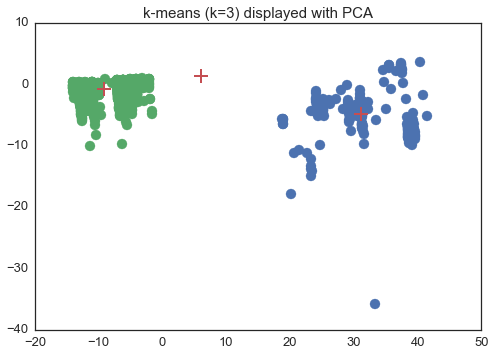

In [130]:
# PCA for dimensionality reduction
pca = skd.PCA(n_components=3)
traits_pca = pca.fit_transform(dfsample)

# K-means
kmeans_model = skc.KMeans(3).fit(dfsample)
centroids = kmeans_model.cluster_centers_
centroids_pca = pca.transform(centroids)
cluster_labels = kmeans_model.labels_

# Plot the results on 2-D scatterplot with cluster centroids
plt.scatter(traits_pca[cluster_labels==0,0], 
            traits_pca[cluster_labels==0,1],
            s=100, color='b')
plt.scatter(traits_pca[cluster_labels==1,0], 
            traits_pca[cluster_labels==1,1],
            s=100, color='g')
plt.scatter(centroids_pca[:,0], centroids_pca[:,1], marker='+', s=200,
            linewidths=2, color='r')
plt.title('k-means (k=3) displayed with PCA', fontsize=15);

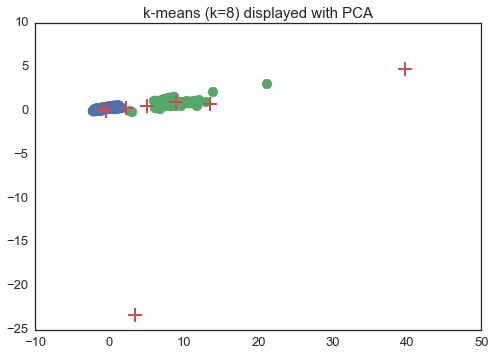

In [168]:
# PCA for dimensionality reduction
pca = skd.PCA(n_components=8)
traits_pca = pca.fit_transform(dfsample)

# K-means
kmeans_model = skc.KMeans(8).fit(dfsample)
centroids = kmeans_model.cluster_centers_
centroids_pca = pca.transform(centroids)
cluster_labels = kmeans_model.labels_

# Plot the results on 2-D scatterplot with cluster centroids
plt.scatter(traits_pca[cluster_labels==0,0], 
            traits_pca[cluster_labels==0,1],
            s=100, color='b')
plt.scatter(traits_pca[cluster_labels==1,0], 
            traits_pca[cluster_labels==1,1],
            s=100, color='g')
plt.scatter(centroids_pca[:,0], centroids_pca[:,1], marker='+', s=200,
            linewidths=2, color='r')
plt.title('k-means (k=8) displayed with PCA', fontsize=15);

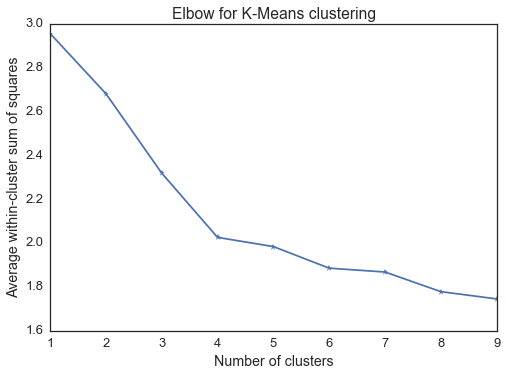

In [169]:
X = dfsample.ix[:,:-1]  # Using the the dataset of Section 1
K = range(1,10)  # Apply kmeans 1 to 10
kmeans_models = [skc.KMeans(k).fit(X) for k in K]
centroids = [m.cluster_centers_ for m in kmeans_models]
D_k = [spd.cdist(X, cent, 'euclidean') for cent in centroids]
cIdx = [np.argmin(D,axis=1) for D in D_k]
dist = [np.min(D,axis=1) for D in D_k]
avgWithinSS = [sum(d)/X.shape[0] for d in dist]

# plot elbow curve
plt.plot(K, avgWithinSS, 'b*-')
plt.xlabel('Number of clusters');
plt.ylabel('Average within-cluster sum of squares');
plt.title('Elbow for K-Means clustering');

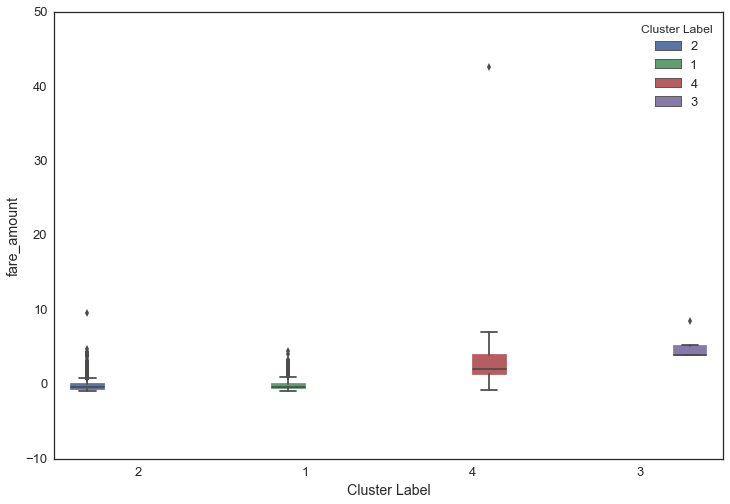

In [170]:
plt.figure(figsize=(12,8));
sns.boxplot(x='Cluster Label', y='fare_amount', data=dfsample, 
            hue='Cluster Label');

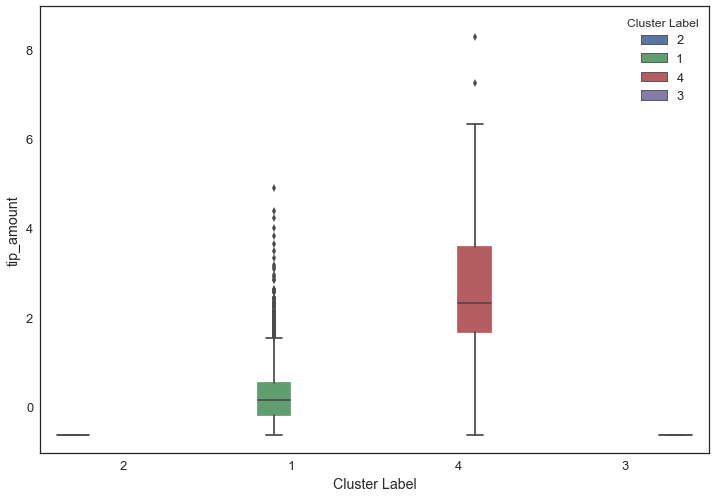

In [171]:
plt.figure(figsize=(12,8));
sns.boxplot(x='Cluster Label', y='tip_amount', data=dfsample, 
            hue='Cluster Label');

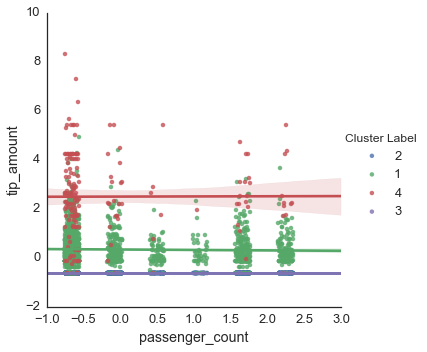

In [172]:
sns.lmplot(x='passenger_count', y='tip_amount', hue='Cluster Label', 
           data=dfsample, fit_reg=True, x_jitter=.1);

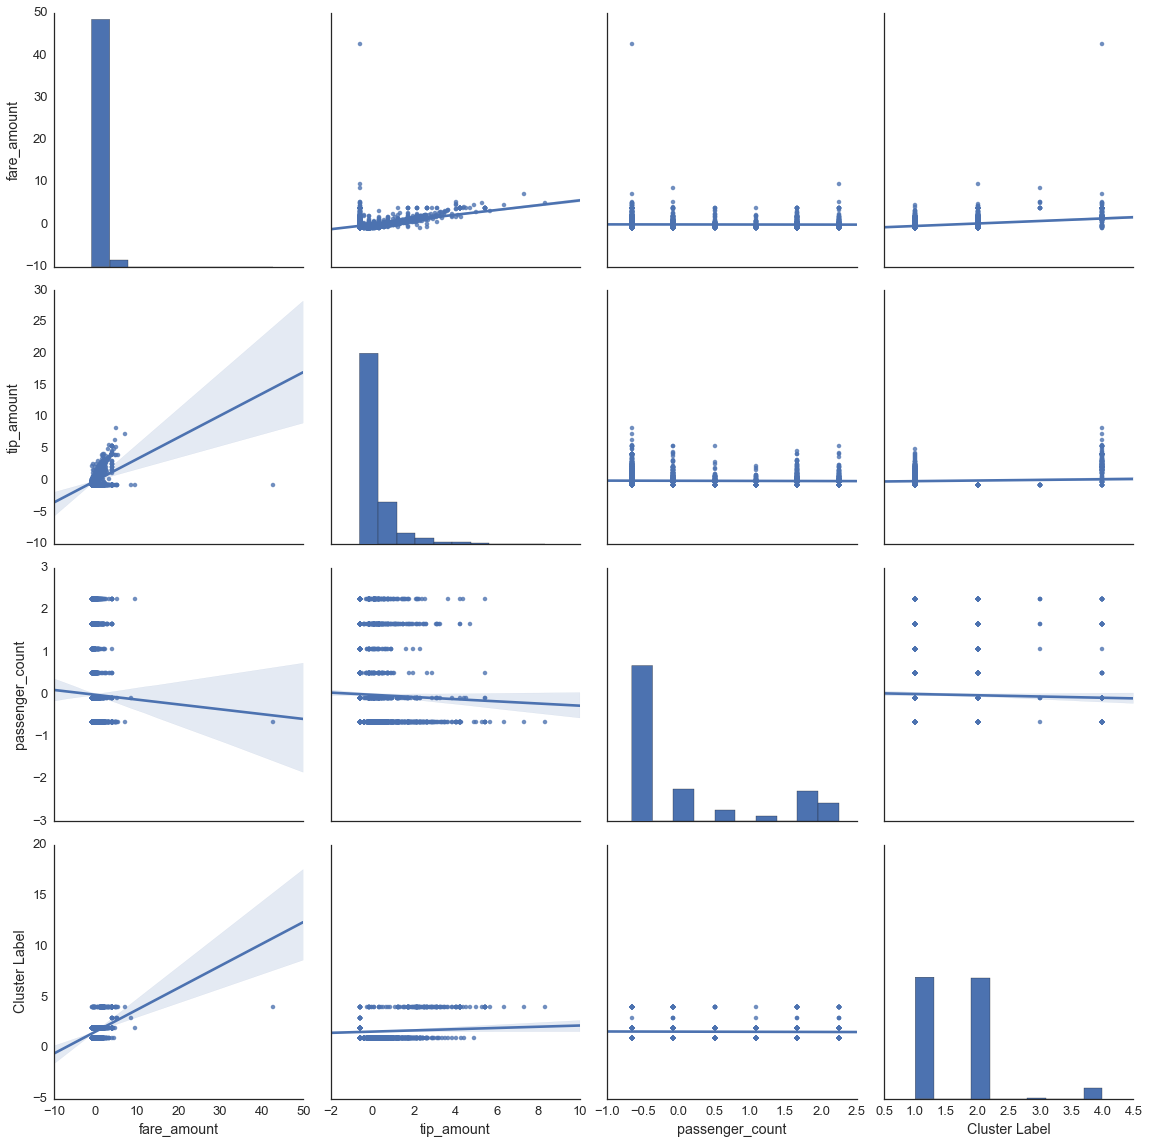

In [183]:
sns.pairplot(dfsample, size = 4, kind="reg", vars=['fare_amount','tip_amount','passenger_count','Cluster Label'])

In [185]:
cluster = dfsample.groupby(dfsample['Cluster Label']).mean()
cluster

,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,rate_code,passenger_count,trip_time_in_secs,trip_distance,CMT,VTS,CSH,DIS,NOC,CRD
Cluster Label,,,,,,,,,,,,,,,,
1,-0.121938,0.067544,0.056976,0.339080,-0.214000,-0.060571,-0.129678,0.005103,-0.029605,-0.127137,-0.060237,0.060237,-0.939756,-0.001381,-0.000977,0.936276
2,-0.128342,-0.030008,0.056976,-0.609327,-0.077018,-0.222988,-0.056307,-0.011217,-0.126729,-0.110453,-0.051454,0.051454,1.064105,-0.001381,-0.000977,-1.062129
3,4.734116,-0.698055,-5.225440,-0.609327,6.238698,4.418727,5.301950,1.026784,3.009889,5.335002,-0.060237,0.060237,1.064105,-0.001381,-0.000977,-1.062129
4,2.568188,-0.345509,-0.738868,2.498634,3.215521,2.885062,2.037603,-0.141331,1.548647,2.182619,1.916529,-1.916529,-0.939756,-0.001381,-0.000977,0.930185


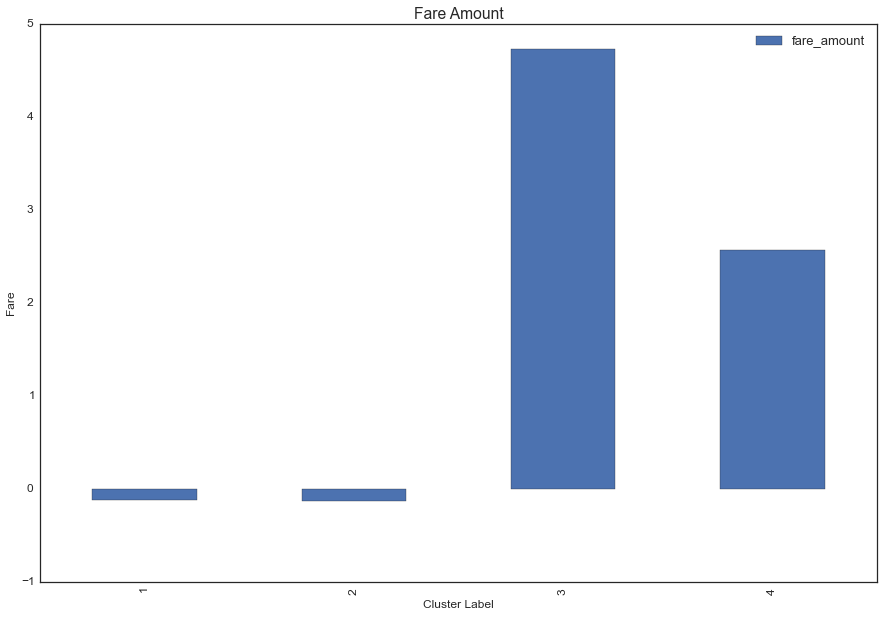

In [186]:
ax = cluster[['fare_amount']].plot(kind='bar', title ="Fare Amount",figsize=(15,10),
                legend=True, fontsize=12)
ax.set_xlabel("Cluster Label",fontsize=12)
ax.set_ylabel("Fare",fontsize=12)
plt.show()

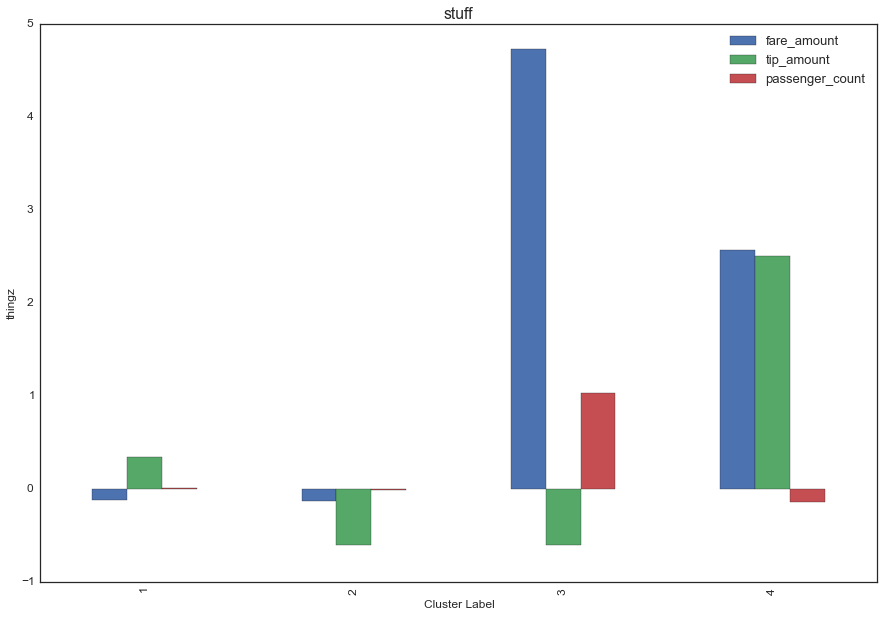

In [187]:
ax = cluster[['fare_amount','tip_amount','passenger_count']].plot(kind='bar', title ="stuff",figsize=(15,10),
                legend=True, fontsize=12)
ax.set_xlabel("Cluster Label",fontsize=12)
ax.set_ylabel("thingz",fontsize=12)
plt.show()

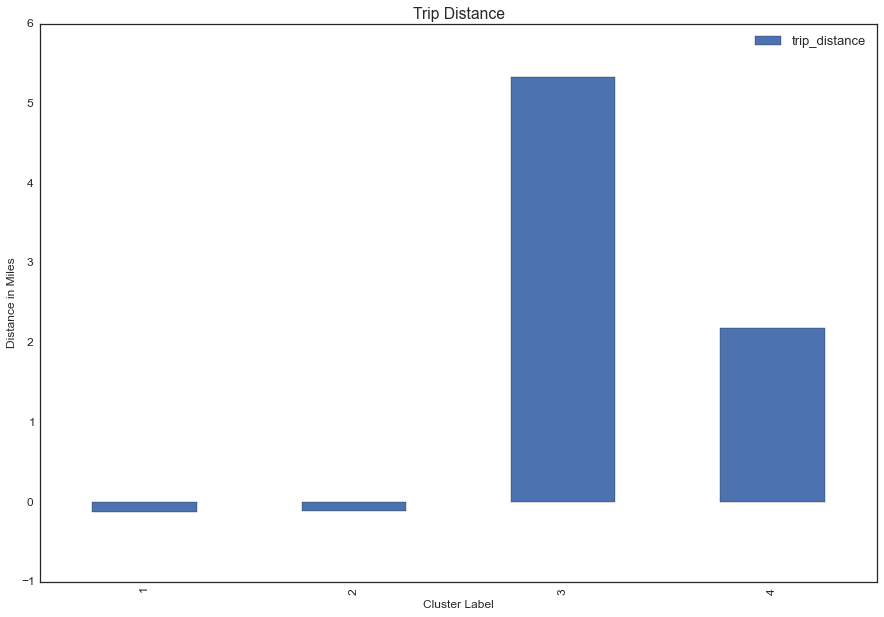

In [188]:
ax = cluster[['trip_distance']].plot(kind='bar', title ="Trip Distance",figsize=(15,10),
                legend=True, fontsize=12)
ax.set_xlabel("Cluster Label",fontsize=12)
ax.set_ylabel("Distance in Miles",fontsize=12)
plt.show()

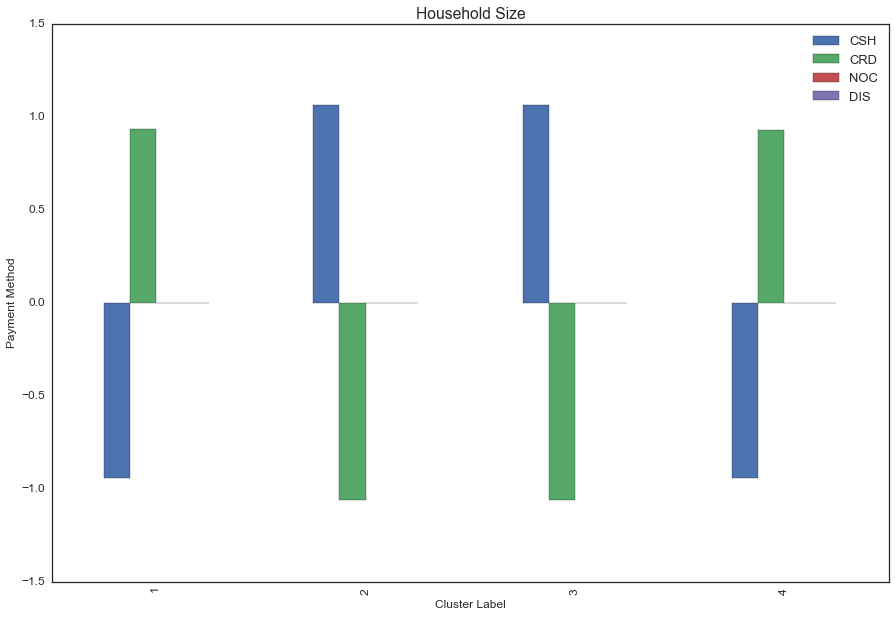

In [191]:
ax = cluster[['CSH','CRD','NOC','DIS']].plot(kind='bar', title ="Household Size",figsize=(15,10),
                legend=True, fontsize=12)
ax.set_xlabel("Cluster Label",fontsize=12)
ax.set_ylabel("Payment Method",fontsize=12)
plt.show()

In [173]:
# Create a PCA model
pca_model = skd.PCA().fit(dfsample.ix[:,:-1])

pca_model.components_.shape

(16, 16)

In [174]:
# Look at the variances explained by each component.
# These values equal to the eigenvalues of the correlation matrix.
pca_model.explained_variance_

array([  5.18043520e+00,   3.06201420e+00,   2.17552078e+00,
         1.25334199e+00,   1.02138064e+00,   9.71822046e-01,
         7.33393868e-01,   4.53876622e-01,   3.59713871e-01,
         2.56378611e-01,   1.54801616e-01,   2.97800874e-03,
         1.88076577e-32,   9.34664289e-34,   1.87877665e-37,
         0.00000000e+00])

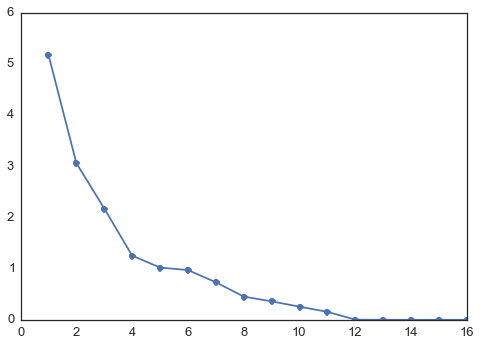

In [178]:
# A "scree" plot.
plt.plot(range(1,17), pca_model.explained_variance_, 'b-o')

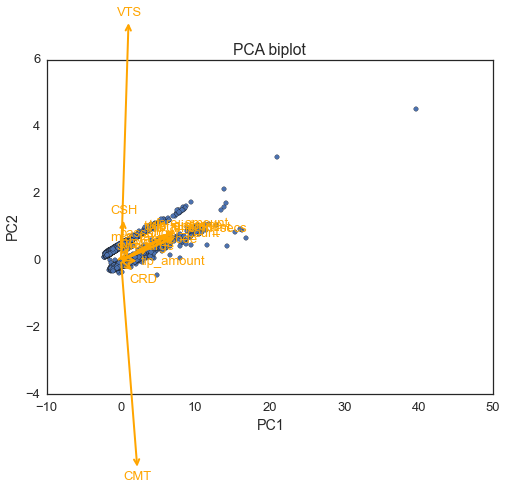

In [179]:
# Scatterplot of disaggregated data
X = pca_model.transform(dfsample.ix[:,:-1])
plt.figure(figsize=(8,6))
plt.scatter(X[:,0], X[:,1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA biplot')
plt.ylim(-4, 6)

# Add variable unit vector projections
V = pca_model.transform(np.identity(X.shape[1]))
for i, v in enumerate(V):
    plt.annotate(dfsample.columns[i], 
                 xy=(0,0), xytext=v[:2]*10, 
                 fontsize=13, color='orange',
                 arrowprops=dict(
                    arrowstyle='<-', linewidth=2, color='orange'))